In [2]:
!pip install -q feature_engine
!pip install tensorflow
!pip install shap
!pip install seaborn
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.0 MB/s eta 0:00:00


In [15]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from feature_engine.encoding import RareLabelEncoder

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

import os

In [9]:
df = pd.read_csv("/content/sample_data/FIFA23_official_data.csv")
print(df.shape)
df.sample(5).T

(17660, 29)


,3692,11611,6765,14836,22
ID,229649,242260,257030,257657,176580
Name,G. Suazo,B. Šerbečić,21 A. Ghezzi,21 D. Bashlay,L. Suárez
Age,24,24,19,30,35
Photo,https://cdn.sofifa.net/players/229/649/23_60.png,https://cdn.sofifa.net/players/242/260/23_60.png,https://cdn.sofifa.net/players/257/030/21_60.png,https://cdn.sofifa.net/players/257/657/21_60.png,https://cdn.sofifa.net/players/176/580/23_60.png
Nationality,Chile,Bosnia and Herzegovina,Italy,Ukraine,Uruguay
Flag,https://cdn.sofifa.net/flags/cl.png,https://cdn.sofifa.net/flags/ba.png,https://cdn.sofifa.net/flags/it.png,https://cdn.sofifa.net/flags/ua.png,https://cdn.sofifa.net/flags/uy.png
Overall,67,66,59,59,84
Potential,69,71,74,59,84
Club,Colo-Colo,Aalesunds FK,Brescia,Podbeskidzie Bielsko-Biała,Club Nacional de Football
Club Logo,https://cdn.sofifa.net/teams/110980/30.png,https://cdn.sofifa.net/teams/1755/30.png,https://cdn.sofifa.net/teams/190/30.png,https://cdn.sofifa.net/teams/111087/30.png,https://cdn.sofifa.net/teams/111325/30.png


In [10]:
label = 'Wage'
# transform main label
def wage_transform(salary):
    salary = salary.replace('€', '').replace('K', '000')
    try:
        res = int(salary)
        return res
    except:
        return None
df[label] = df[label].apply(wage_transform)
# exclude players with zero salary
df = df[df[label]>0]
# further log10-transform main label
df[label] = df[label].apply(lambda x: np.log10(x))
# Exclude 1% of smallest and 1% of highest salaries
P = np.percentile(df[label], [1, 99])
df = df[(df[label] > P[0]) & (df[label] < P[1])]
# transform joined
def transform_joined(s):
    try:
        if ', ' in str(s):
            res = str(s).split(', ')[-1]
        else:
            res = str(s)
        return res
    except:
        return 'None'
df['Joined'] = df['Joined'].apply(transform_joined)
# transform contract valid until
def transform_contract_valid(s):
    try:
        if ', ' in str(s):
            res = str(s).split(', ')[-1]
        else:
            res = str(s)
        if res >= '2023':
            return res
        else:
            return 'Expired'
    except:
        return 'None'
df['Contract Valid Until'] = df['Contract Valid Until'].apply(transform_contract_valid)
# select only valid contracts
df = df[(df['Contract Valid Until'] > '2022')&(df['Contract Valid Until'] != 'Expired')&(df['Contract Valid Until'] != 'nan')]
# transform International Reputation, Weak Foot, and Skill Moves to string
for col in ['International Reputation', 'Weak Foot', 'Skill Moves']:
    df[col] = df[col].apply(lambda x: str(int(x)))
# bin overall, potential, and special to larger bins
df['Overall'] = df['Overall'].apply(lambda x: 2*round(1/2*x))
df['Potential'] = df['Potential'].apply(lambda x: 5*round(1/5*x))
df['Special'] = df['Special'].apply(lambda x: 100*round(1/100*x))
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Nationality', 'Preferred Foot', 'Body Type']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=30/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# finally, drop unused columns
cols2drop = ['ID', 'Name', 'Photo', 'Flag', 'Club', 'Club Logo', 'Loaned From',
             'Kit Number', 'Best Overall Rating', 'Value', 'Release Clause',
             'Position', 'Work Rate', 'Weight', 'Height', 'Real Face']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(9973, 13)


,2802,325,3799,6906,2372
Age,24,27,24,23,28
Nationality,Republic of Ireland,Slovakia,Belgium,Brazil,Norway
Overall,66,80,66,68,70
Potential,70,80,70,75,70
Wage,4.0,4.80618,3.477121,3.60206,4.230449
Special,1800,2100,1800,1600,1800
Preferred Foot,Right,Right,Right,Right,Right
International Reputation,1,2,1,1,1
Weak Foot,2,4,3,4,4
Skill Moves,3,3,2,3,3


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,9973.0,23.367492,4.220627,16.000000,20.0,22.000000,26.000000,44.000000
Overall,9973.0,65.319763,7.732810,44.000000,60.0,64.000000,72.000000,90.000000
Potential,9973.0,72.519302,6.451690,50.000000,70.0,75.000000,75.000000,90.000000
Wage,9973.0,3.581879,0.580464,2.740363,3.0,3.477121,4.041393,4.954243
Special,9973.0,1595.898927,273.352239,800.000000,1400.0,1600.000000,1800.000000,2300.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 2 to 17657
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9973 non-null   int64  
 1   Nationality               9973 non-null   object 
 2   Overall                   9973 non-null   int64  
 3   Potential                 9973 non-null   int64  
 4   Wage                      9973 non-null   float64
 5   Special                   9973 non-null   int64  
 6   Preferred Foot            9973 non-null   object 
 7   International Reputation  9973 non-null   object 
 8   Weak Foot                 9973 non-null   object 
 9   Skill Moves               9973 non-null   object 
 10  Body Type                 9973 non-null   object 
 11  Joined                    9973 non-null   object 
 12  Contract Valid Until      9973 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 1.1+ MB


In [13]:
# initialize data
y = df[label].values.reshape(-1,)
X = df.drop([label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4986, 12), (4987, 12), (4986,), (4987,))

In [16]:
# initialize Pool
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostRegressor(iterations=1000,
                          depth=5,
                          verbose=0,
                          learning_rate=0.05,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} dex, and for test {round(rmse_test,3)} dex")

RMSE score for train 0.256 dex, and for test 0.279 dex


In [17]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} dex, and for test {round(rmse_bs_test,3)} dex")

RMSE baseline score for train 0.578 dex, and for test 0.583 dex


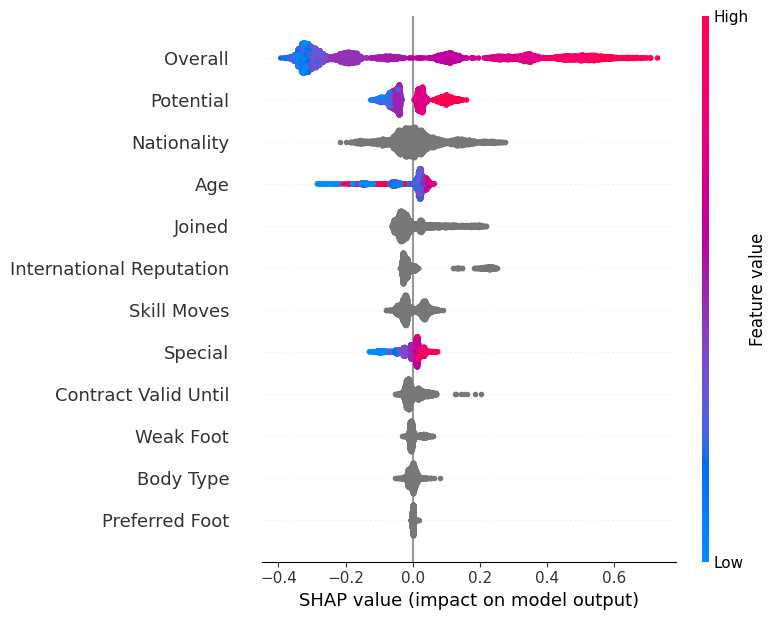

In [18]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [19]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(10**(expected_values-3),1)} k€/week")
print(f"Average actual salary is {round(10**(np.mean(y_test)-3),1)} k€/week")

Average predicted salary is 3.9 k€/week
Average actual salary is 3.7 k€/week



Age



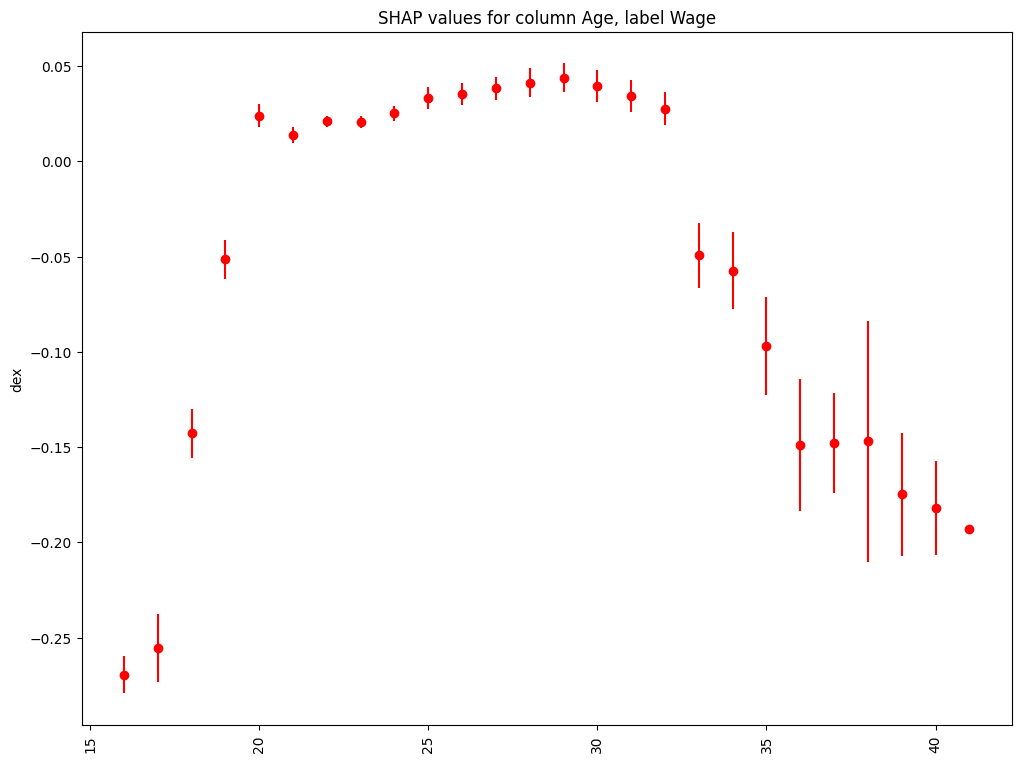

       gain  gain_std  count
col                         
29   0.0438    0.0077    152
28   0.0413    0.0075    188
30   0.0395    0.0085    145
27   0.0383    0.0059    236
26   0.0352    0.0059    258
31   0.0342    0.0086     96
25   0.0333    0.0058    297
32   0.0276    0.0087     76
24   0.0251    0.0039    366
20   0.0240    0.0062    606
22   0.0210    0.0029    525
23   0.0206    0.0030    387
21   0.0137    0.0041    606
33  -0.0494    0.0171     57
19  -0.0515    0.0102    518
34  -0.0574    0.0204     48
35  -0.0969    0.0257     36
18  -0.1429    0.0128    293
38  -0.1471    0.0634      2
37  -0.1481    0.0262     10
36  -0.1488    0.0347     21
39  -0.1749    0.0323      6
40  -0.1821    0.0245      4
41  -0.1932       NaN      1
17  -0.2556    0.0180     45
16  -0.2695    0.0097      8

Nationality



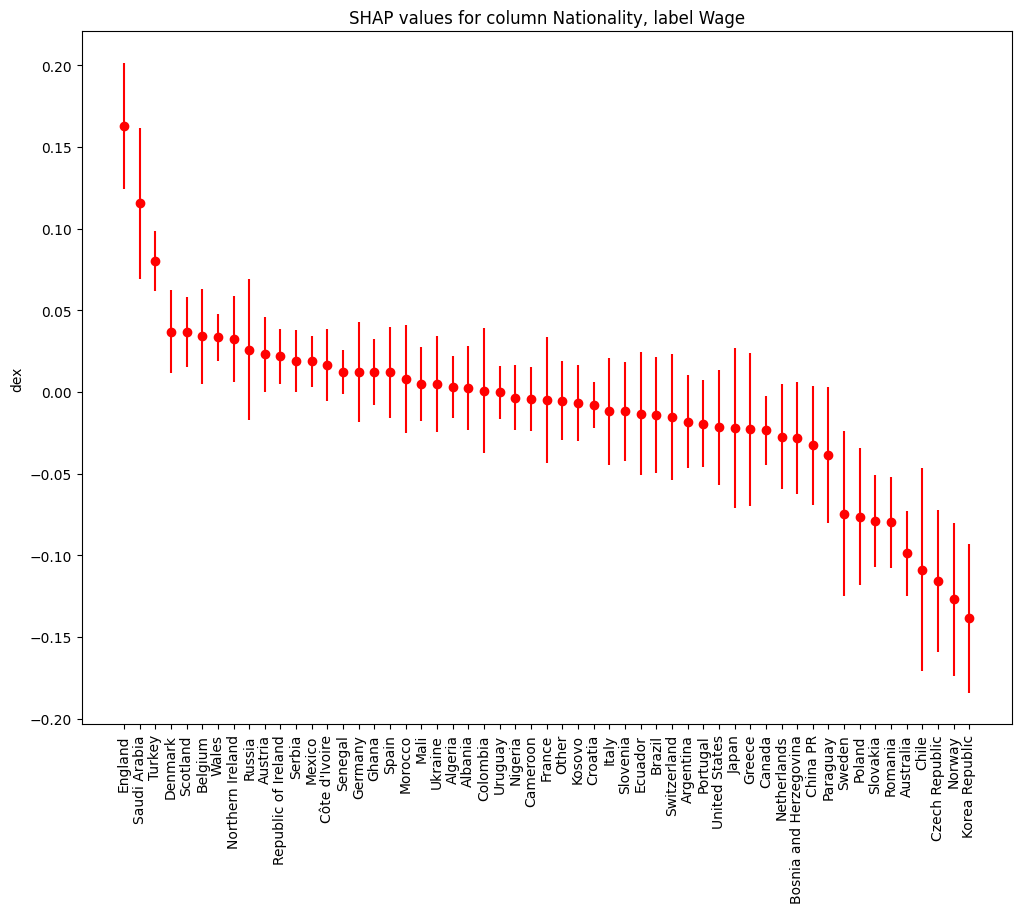

                          gain  gain_std  count
col                                            
England                 0.1627    0.0387    503
Saudi Arabia            0.1154    0.0464     91
Turkey                  0.0800    0.0185    131
Denmark                 0.0370    0.0256     78
Scotland                0.0368    0.0213     59
Belgium                 0.0341    0.0290     91
Wales                   0.0334    0.0145     50
Northern Ireland        0.0323    0.0265     21
Russia                  0.0259    0.0430     16
Austria                 0.0230    0.0230     81
Republic of Ireland     0.0217    0.0171     59
Serbia                  0.0187    0.0190     39
Mexico                  0.0187    0.0154     70
Côte d'Ivoire           0.0167    0.0220     33
Senegal                 0.0124    0.0135     32
Germany                 0.0123    0.0306    325
Ghana                   0.0123    0.0201     42
Spain                   0.0120    0.0280    343
Morocco                 0.0079    0.0331

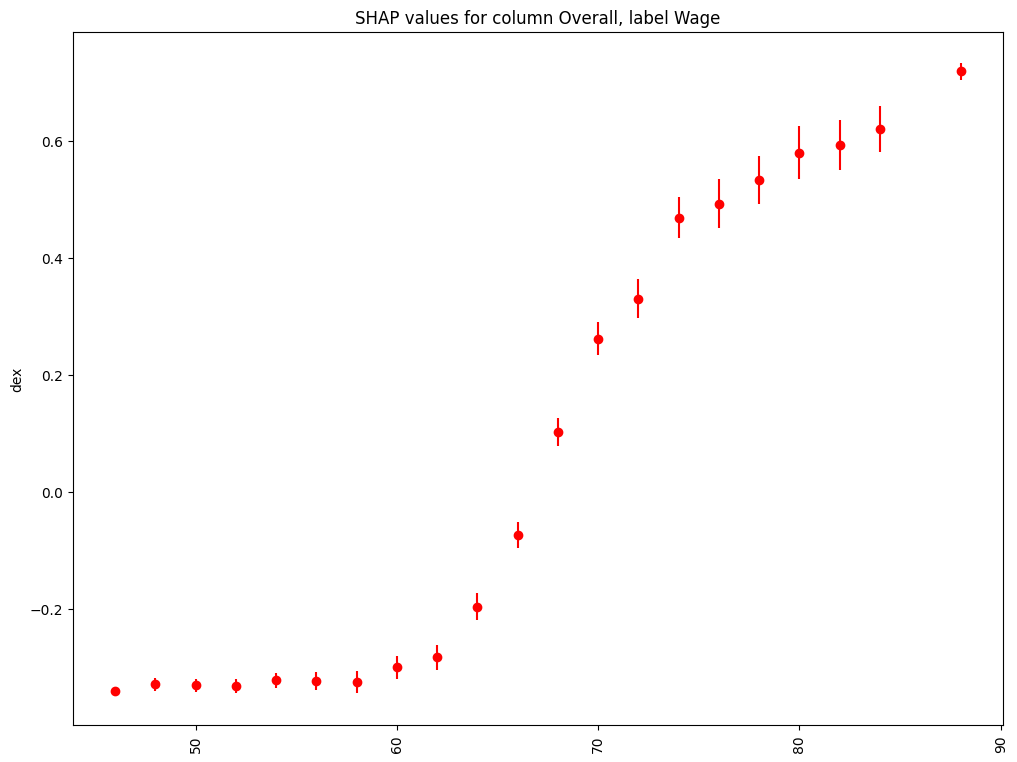

       gain  gain_std  count
col                         
88   0.7194    0.0142      2
84   0.6209    0.0394     34
82   0.5940    0.0431     25
80   0.5806    0.0448    176
78   0.5338    0.0404     73
76   0.4935    0.0421    379
74   0.4695    0.0347    137
72   0.3308    0.0337    497
70   0.2624    0.0279    171
68   0.1035    0.0241    574
66  -0.0731    0.0225    222
64  -0.1956    0.0228    763
62  -0.2824    0.0215    260
60  -0.2997    0.0194    703
54  -0.3217    0.0128     92
56  -0.3229    0.0156    393
58  -0.3246    0.0191    167
48  -0.3289    0.0104     47
50  -0.3304    0.0108     42
52  -0.3316    0.0119    228
46  -0.3403    0.0006      2

Potential



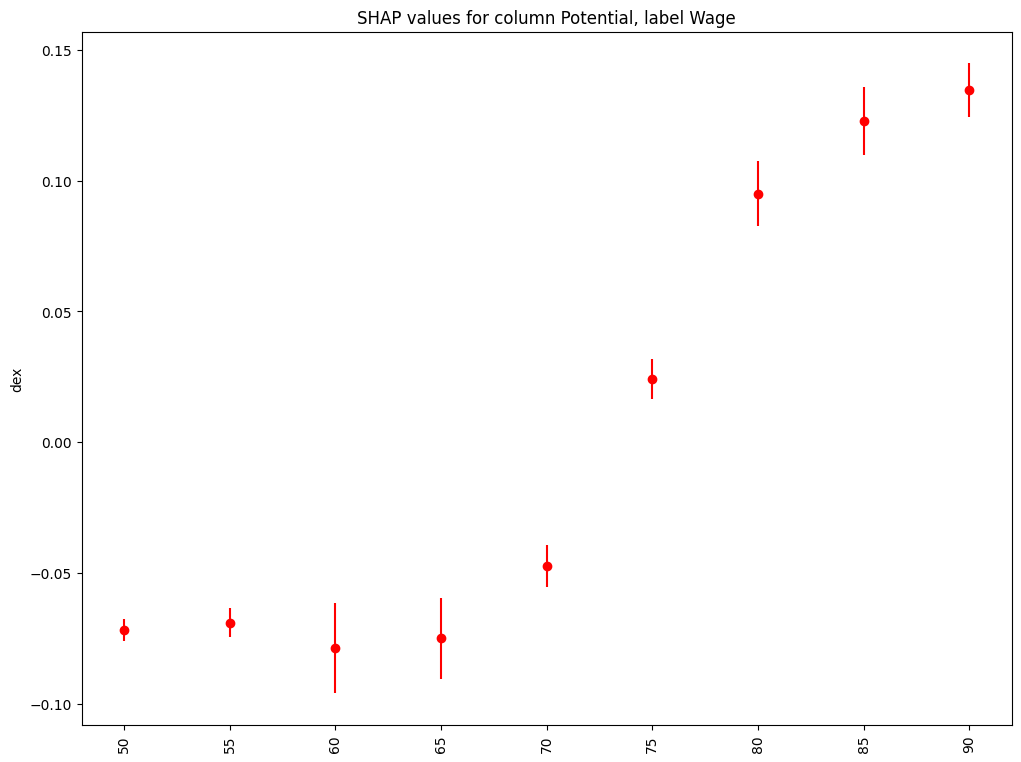

       gain  gain_std  count
col                         
90   0.1346    0.0103     18
85   0.1229    0.0130    228
80   0.0950    0.0125    815
75   0.0240    0.0077   1442
70  -0.0475    0.0080   1442
55  -0.0690    0.0055     57
50  -0.0719    0.0041      5
65  -0.0750    0.0155    751
60  -0.0787    0.0173    229

Special



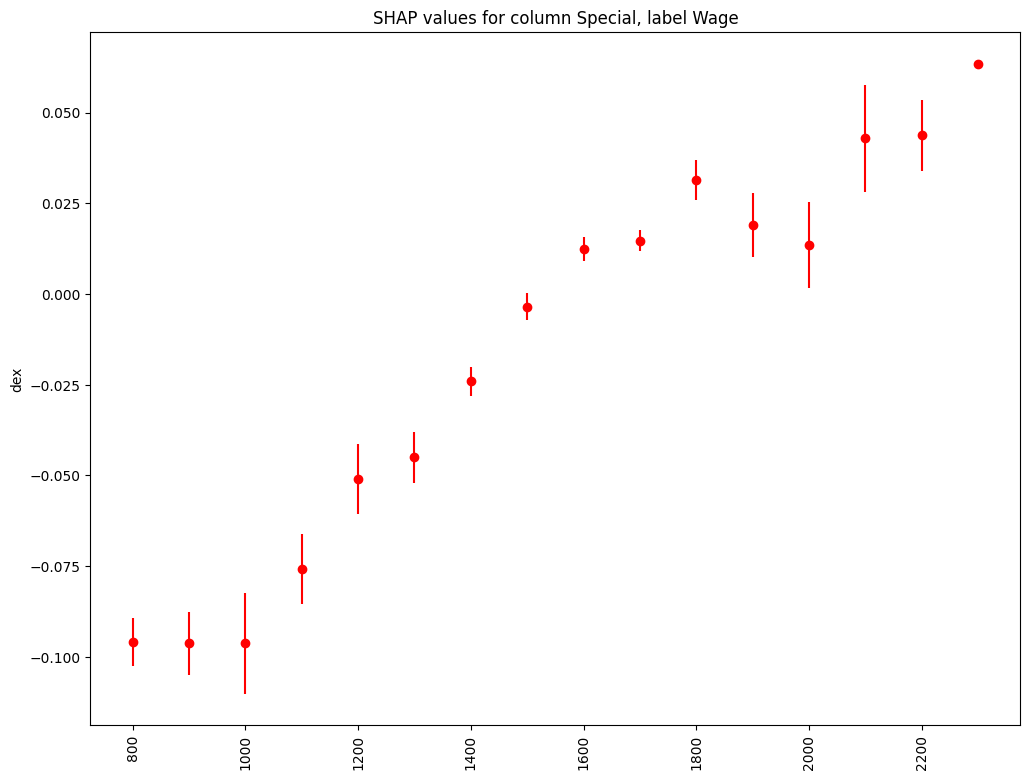

        gain  gain_std  count
col                          
2300  0.0635       NaN      1
2200  0.0437    0.0097     31
2100  0.0429    0.0147    122
1800  0.0314    0.0055    617
1900  0.0191    0.0088    416
1700  0.0147    0.0028    664
2000  0.0135    0.0118    284
1600  0.0124    0.0034    788
1500 -0.0035    0.0037    764
1400 -0.0240    0.0040    555
1300 -0.0450    0.0070    295
1200 -0.0509    0.0096    134
1100 -0.0757    0.0096     66
800  -0.0958    0.0066     57
900  -0.0963    0.0086    117
1000 -0.0963    0.0138     76

Preferred Foot



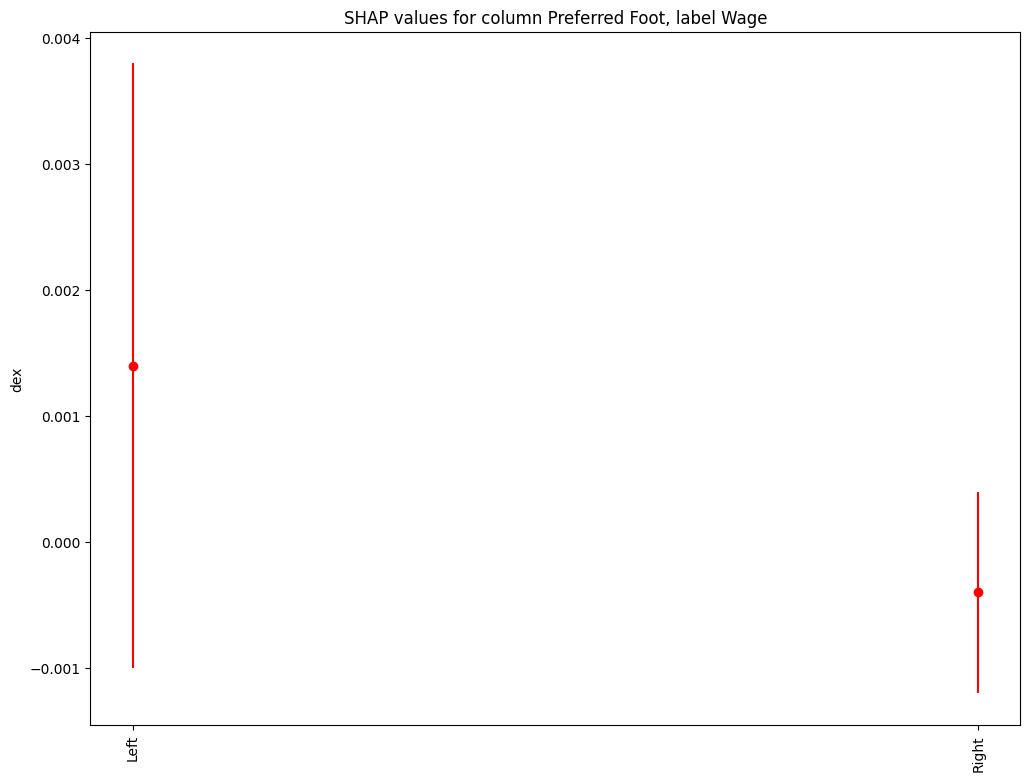

         gain  gain_std  count
col                           
Left   0.0014    0.0024   1178
Right -0.0004    0.0008   3809

International Reputation



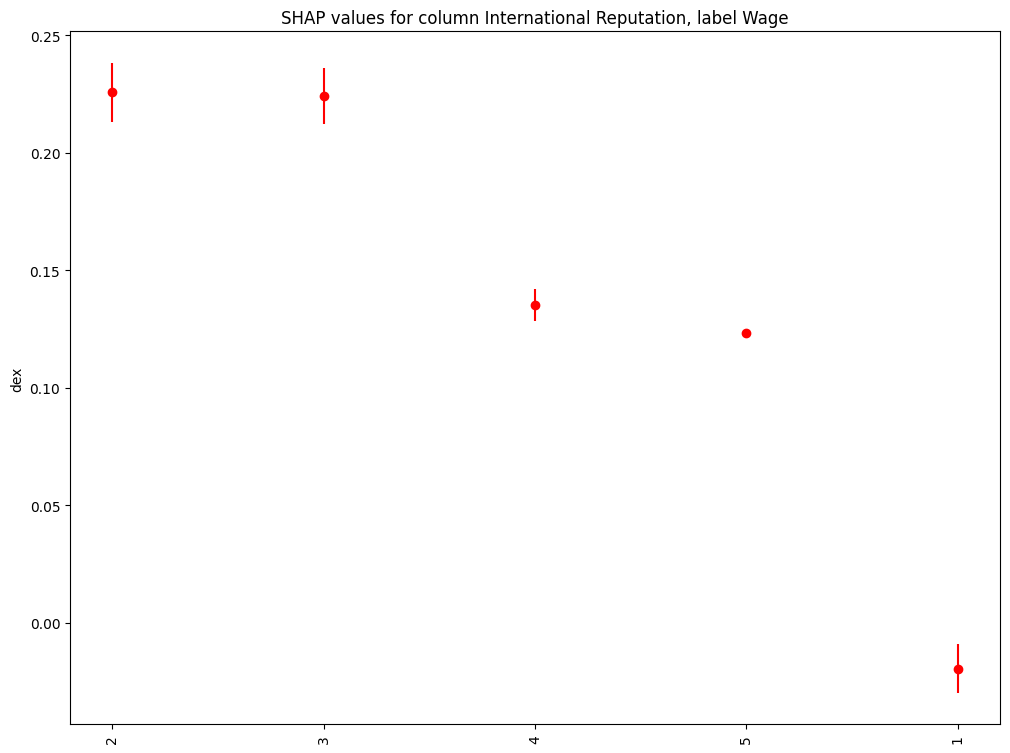

       gain  gain_std  count
col                         
2    0.2257    0.0125    313
3    0.2240    0.0120     82
4    0.1352    0.0070     12
5    0.1233       NaN      1
1   -0.0195    0.0103   4579

Weak Foot



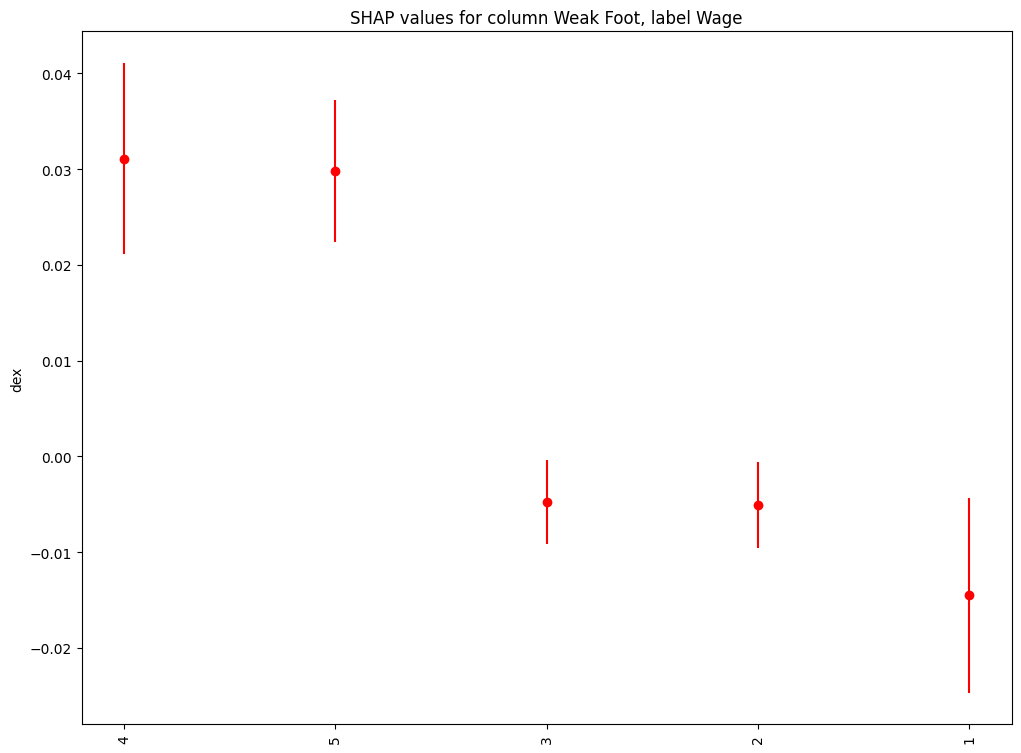

       gain  gain_std  count
col                         
4    0.0311    0.0100    679
5    0.0298    0.0074     86
3   -0.0048    0.0044   3154
2   -0.0051    0.0045   1044
1   -0.0145    0.0102     24

Skill Moves



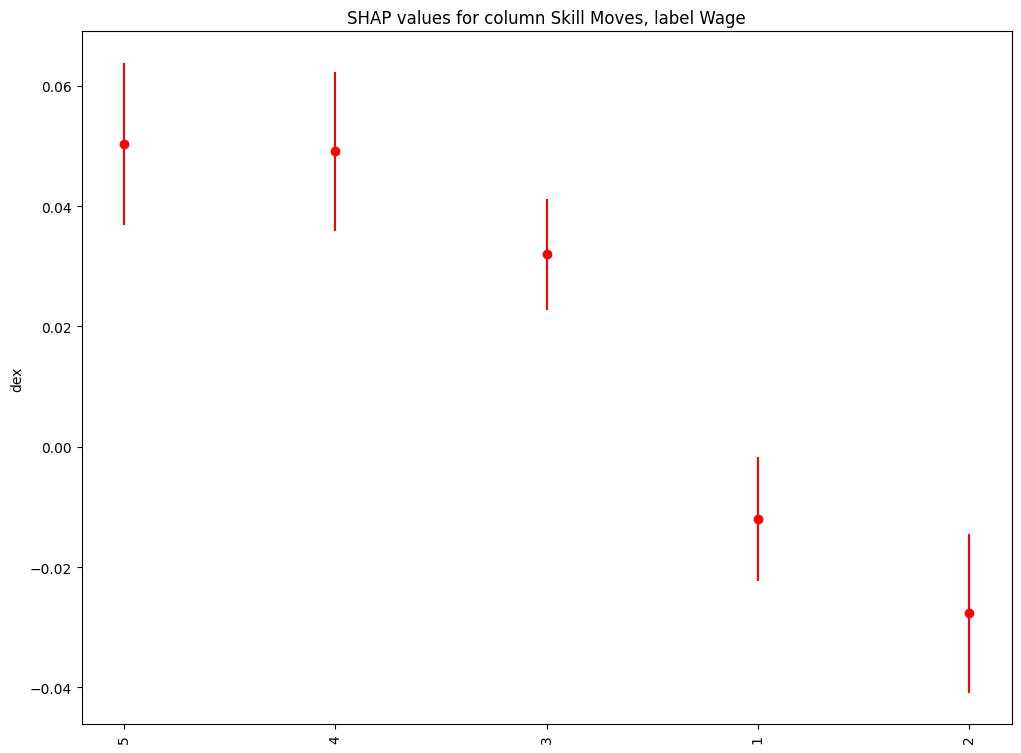

       gain  gain_std  count
col                         
5    0.0503    0.0135     16
4    0.0491    0.0132    344
3    0.0320    0.0092   1594
1   -0.0120    0.0103    418
2   -0.0277    0.0132   2615

Body Type



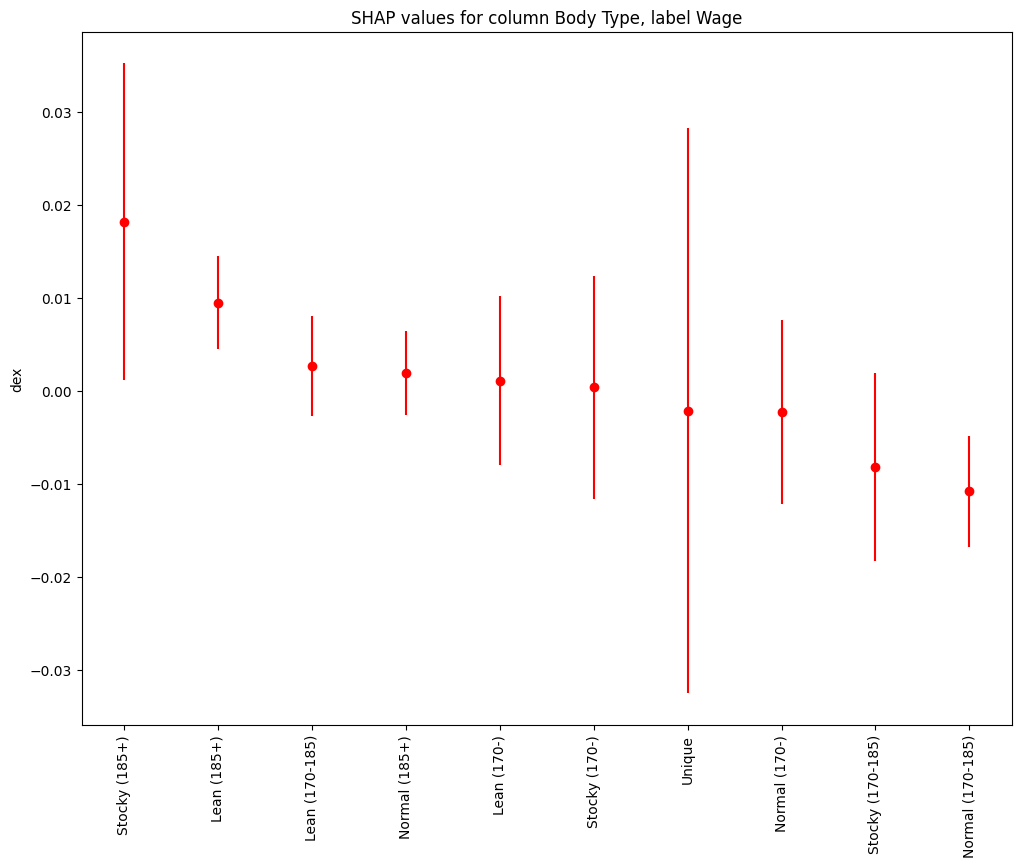

                    gain  gain_std  count
col                                      
Stocky (185+)     0.0182    0.0170     87
Lean (185+)       0.0095    0.0050    580
Lean (170-185)    0.0027    0.0054   1138
Normal (185+)     0.0019    0.0045   1081
Lean (170-)       0.0011    0.0091    116
Stocky (170-)     0.0004    0.0120     18
Unique           -0.0021    0.0304     26
Normal (170-)    -0.0023    0.0099    163
Stocky (170-185) -0.0082    0.0101    127
Normal (170-185) -0.0108    0.0060   1651

Joined



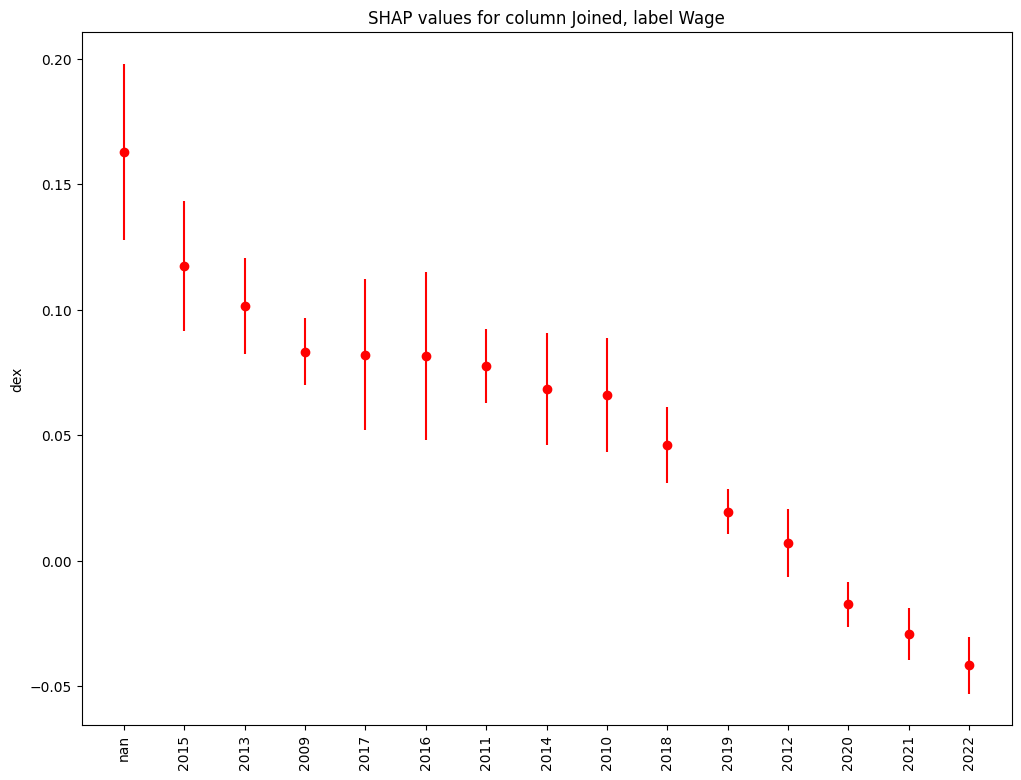

        gain  gain_std  count
col                          
nan   0.1631    0.0351    224
2015  0.1175    0.0260     50
2013  0.1016    0.0190     12
2009  0.0834    0.0135      7
2017  0.0822    0.0300    124
2016  0.0815    0.0335     81
2011  0.0775    0.0147     10
2014  0.0685    0.0222     31
2010  0.0662    0.0227      5
2018  0.0463    0.0152    227
2019  0.0196    0.0091    549
2012  0.0070    0.0135      8
2020 -0.0173    0.0089    984
2021 -0.0292    0.0105   1316
2022 -0.0416    0.0113   1359

Contract Valid Until



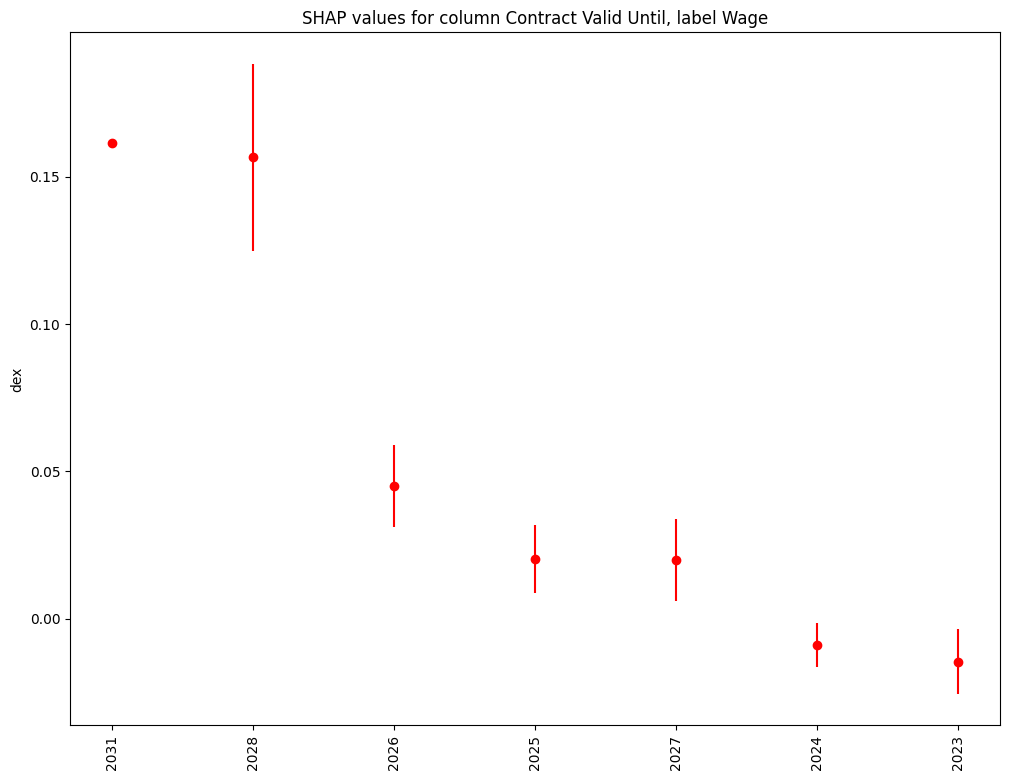

        gain  gain_std  count
col                          
2031  0.1614       NaN      1
2028  0.1565    0.0318      6
2026  0.0450    0.0140    474
2025  0.0201    0.0116    931
2027  0.0200    0.0139    150
2024 -0.0090    0.0074   1361
2023 -0.0146    0.0109   2064


In [20]:
def show_shap(col, shap_values=shap_values, label=label, X_test=X_test, ylabel='dex'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,9))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values, label=label, X_test=X_test)